In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import utils_pk as pk
import utils_data as my
import h5py
from nbodykit.lab import *
plt.style.use('./niceplot2jay.mplstyle')
from nbodykit import setup_logging
setup_logging('warning')

TypeError: 'voxelize' is not a package

## Visualize

In [16]:
Lbox = 1.
Nsize = 512
file = './data/snapshot_659_9.hdf5'
# Read the file
f = h5py.File(file, 'r')
# Load the data
pos = f["PartType0"]["Coordinates"][:]
mass = f["PartType0"]["Masses"][:]
v = f["PartType0"]["Velocities"][:]
rho = f["PartType0"]["Density"][:]
f.close()
# Coordinates begin at (0,0,0)
xmin, xmax = np.min(pos[:,0]), np.max(pos[:,0])
ymin, ymax = np.min(pos[:,1]), np.max(pos[:,1])
zmin = np.min(pos[:,2])
pos[:,0] -= xmin
pos[:,1] -= ymin
pos[:,2] -= zmin
# initialize the catalog
cat = ArrayCatalog({'Position':pos, 'Density':rho})
cat.attrs['BoxSize'] = Lbox
mesh = cat.to_mesh(Nmesh=Nsize, resampler='tsc', position='Position', 
     value='Density', compensated=False, interlaced=False)
grid = mesh.paint()

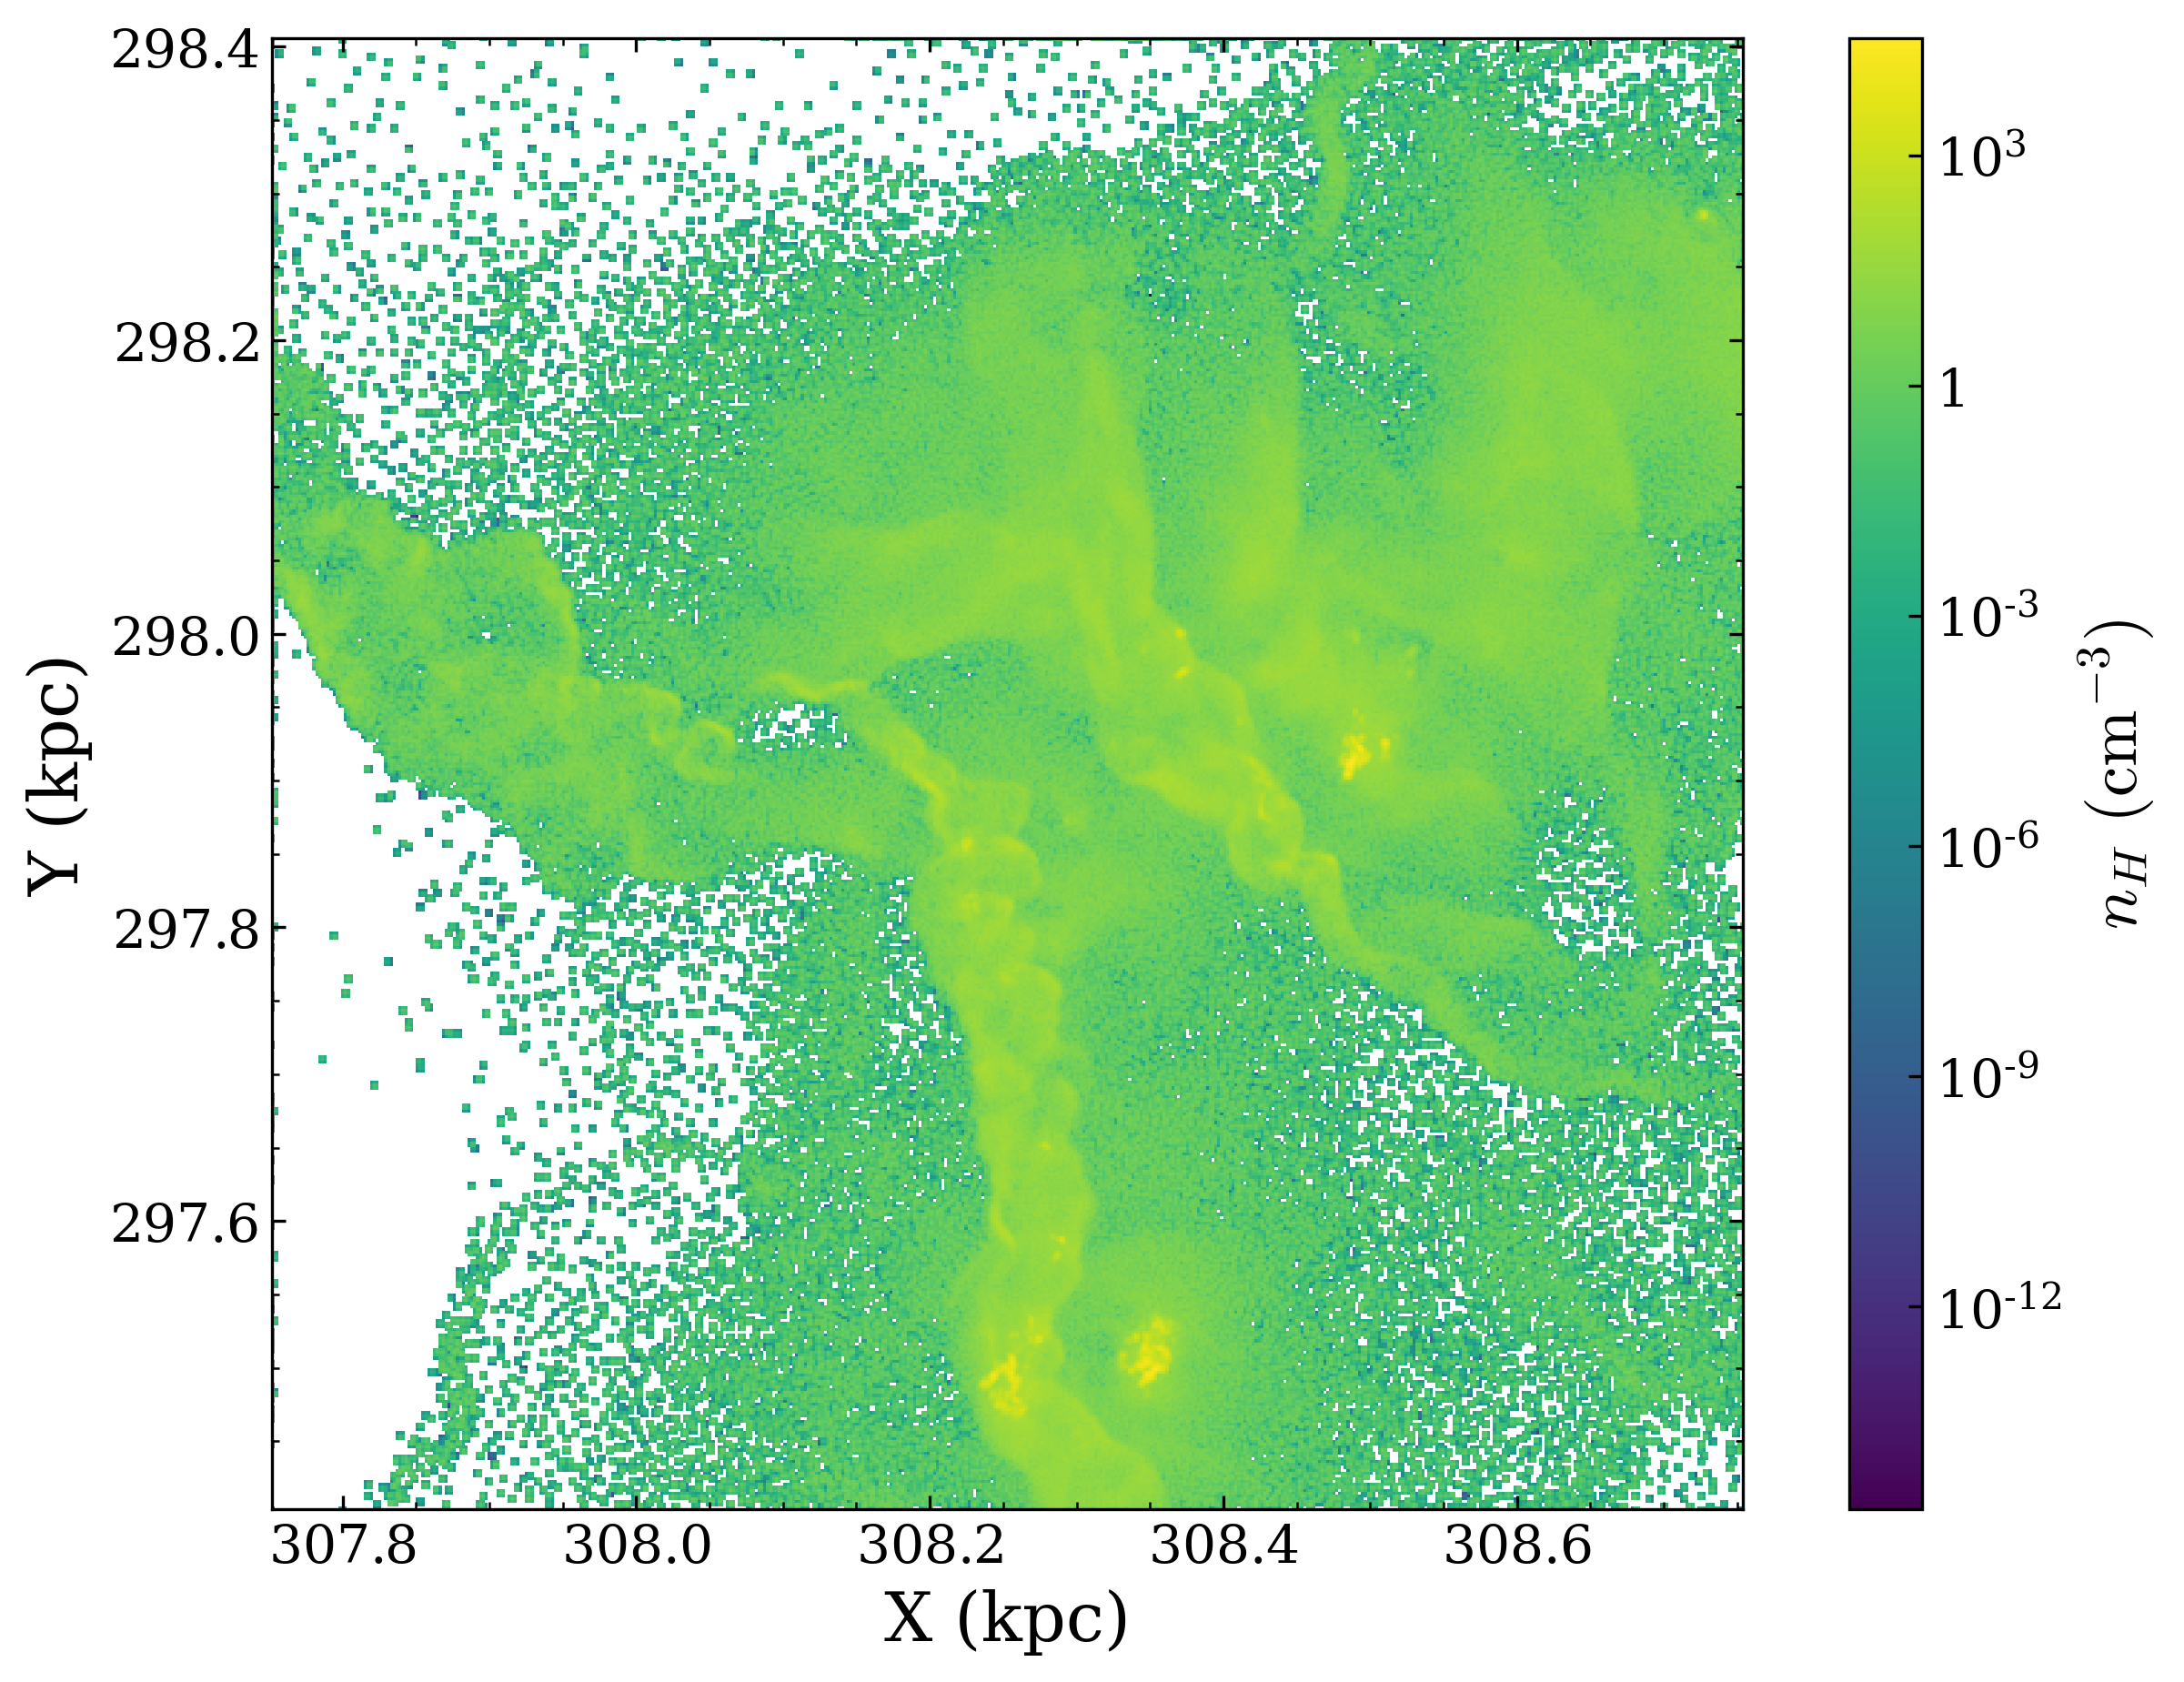

In [17]:
import matplotlib.colors as colors
# Grid
xgrid = np.linspace(xmin, xmax, Nsize)
ygrid = np.linspace(ymin, ymax, Nsize)
X, Y = np.meshgrid(xgrid, ygrid)
# Slice
zslice = int((300 - zmin)/Lbox*Nsize)
density_slice_nHcgs = np.transpose(grid[:,:,zslice]) * 300
# Plot
fig, ax = plt.subplots(figsize=(10,7))
p = ax.pcolormesh(X, Y, density_slice_nHcgs, norm=colors.LogNorm())
ax.set_aspect('equal')
fig.colorbar(p,label=r"$n_H$ $(\rm cm^{-3})$")
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
plt.show()

## Discussion: Interpolation
Is energy the same using physical/non-physical interpolation? Is power spectra the same?

conservation of mass
$\sum_\alpha m_\alpha = \sum_i m_i$

conservation of momentum
$\sum_\alpha m_\alpha v_\alpha = \sum_i m_i v_i$

conservation of energy
$\frac{1}{2} \sum_\alpha m_\alpha |v_\alpha|^2 \approx \frac{1}{2} \sum_i m_i |v_i|^2$

In [12]:
setup_logging('warning')
Nsize = 64
file = './data/snapshot_659_9.hdf5'
Lbox = 1.

# Read the file
f = h5py.File(file, 'r')
# Load the data
pos = f["PartType0"]["Coordinates"][:]
mass = f["PartType0"]["Masses"][:]
v = f["PartType0"]["Velocities"][:]
rho = f["PartType0"]["Density"][:]
Np = len(v)
f.close()

# - center of mass velocity
total_mass = np.sum(mass)
v[:,0] -= np.sum(mass * v[:,0]) / total_mass
v[:,1] -= np.sum(mass * v[:,1]) / total_mass
v[:,2] -= np.sum(mass * v[:,2]) / total_mass

# Coordinates begin at (0,0,0)
xmin = np.min(pos[:,0])
ymin = np.min(pos[:,1])
zmin = np.min(pos[:,2])

pos[:,0] -= xmin
pos[:,1] -= ymin
pos[:,2] -= zmin


In [ ]:
"""TSC COM v"""

# initialize the catalog
cat = ArrayCatalog({'Position':pos, 'vx':v[:,0], 'vy':v[:,1], 'vz':v[:,2],
    'mvx':mass*v[:,0], 'mvy':mass*v[:,1], 'mvz':mass*v[:,2], 'Masses':mass})
cat.attrs['BoxSize'] = Lbox

# convert catalog to a mesh with desired window and interlacing
mesh_mvx = cat.to_mesh(value='mvx', Nmesh=Nsize, resampler='tsc', compensated=False, interlaced=False)
mesh_mvy = cat.to_mesh(value='mvy', Nmesh=Nsize, resampler='tsc', compensated=False, interlaced=False)
mesh_mvz = cat.to_mesh(value='mvz', Nmesh=Nsize, resampler='tsc', compensated=False, interlaced=False)
mvxgrid_tsc = mesh_mvx.paint() * Np/Nsize**3
mvygrid_tsc = mesh_mvy.paint() * Np/Nsize**3
mvzgrid_tsc = mesh_mvz.paint() * Np/Nsize**3

mesh_m = cat.to_mesh(value='Masses', Nmesh=Nsize, resampler='tsc', compensated=False, interlaced=False)
mgrid_tsc = mesh_m.paint() * Np/Nsize**3

mgrid_tsc_ = mgrid_tsc.copy()
mgrid_tsc_[np.where(mgrid_tsc_==0)] = 1

vx_tsc = mvxgrid_tsc / mgrid_tsc_
vy_tsc = mvygrid_tsc / mgrid_tsc_
vz_tsc = mvzgrid_tsc / mgrid_tsc_

"""TSC v with corrections"""
# convert catalog to a mesh with desired window and interlacing
mesh_vx = cat.to_mesh(value='vx', Nmesh=Nsize, resampler='tsc', compensated=False, interlaced=False)
mesh_vy = cat.to_mesh(value='vy', Nmesh=Nsize, resampler='tsc', compensated=False, interlaced=False)
mesh_vz = cat.to_mesh(value='vz', Nmesh=Nsize, resampler='tsc', compensated=False, interlaced=False)

vx_tsc2 = mesh_vx.paint() * Np/Nsize**3
vy_tsc2 = mesh_vy.paint() * Np/Nsize**3
vz_tsc2 = mesh_vz.paint() * Np/Nsize**3

"""NGP COM v"""
mv = v.copy()
mv[:,0] = mv[:,0] * mass
mv[:,1] = mv[:,1] * mass
mv[:,2] = mv[:,2] * mass

mvgrid_ngp = pk.DepositToGrid(mv, pos, Nsize, Lbox)
mgrid_ngp = pk.DepositToGrid(mass, pos, Nsize, Lbox)

mgrid_ngp_ = mgrid_ngp.copy()
mgrid_ngp_[np.where(mgrid_ngp_==0)] = 1

vgrid_ngp = mvgrid_ngp.copy()
vgrid_ngp[:,:,:,0] /= mgrid_ngp_
vgrid_ngp[:,:,:,1] /= mgrid_ngp_
vgrid_ngp[:,:,:,2] /= mgrid_ngp_

vx_ngp = vgrid_ngp[:,:,:,0]
vy_ngp = vgrid_ngp[:,:,:,1]
vz_ngp = vgrid_ngp[:,:,:,2]

"""NGP v"""
v_grid = pk.DepositToGrid(v, pos, Nsize, Lbox)

vx_ngp2 = v_grid[:,:,:,0]
vy_ngp2 = v_grid[:,:,:,1]
vz_ngp2 = v_grid[:,:,:,2]

In [16]:
"""Kinetic Energy"""
cat = ArrayCatalog({'Position':pos, 'vx':v[:,0], 'vy':v[:,1], 'vz':v[:,2],
    'Kinetic Energy':0.5*mass*(v[:,0]**2 + v[:,1]**2 + v[:,2]**2), 'Masses':mass})
cat.attrs['BoxSize'] = Lbox
mesh = cat.to_mesh(value='Kinetic Energy', Nmesh=Nsize, resampler='tsc', compensated=False, interlaced=False)
energy_grid = mesh.paint() * Np/Nsize**3
print(
    '{:.2e}'.format(np.sum(0.5*mass*(v[:,0]**2 + v[:,1]**2 + v[:,2]**2))),
    '{:.2e}'.format(np.sum(energy_grid)),
    '{:.2e}'.format(np.sum(np.abs(np.fft.fftn(energy_grid)/Nsize**(3/2)))),
    '{:.2e}'.format(np.sum(energy_grid**2)),
    '{:.2e}'.format(np.sum(np.abs(np.fft.fftn(energy_grid)/Nsize**(3/2))**2)),
)

In [22]:
"""Momentum"""
cat = ArrayCatalog({'Position':pos, 'vx':v[:,0], 'vy':v[:,1], 'vz':v[:,2],
    'mvx':mass**0.5*v[:,0], 'mvy':mass**0.5*v[:,1], 'mvz':mass**0.5*v[:,2], 'Masses':mass})
cat.attrs['BoxSize'] = Lbox

mesh_mvx = cat.to_mesh(value='mvx', Nmesh=Nsize, resampler='tsc', compensated=False, interlaced=False)
mesh_mvy = cat.to_mesh(value='mvy', Nmesh=Nsize, resampler='tsc', compensated=False, interlaced=False)
mesh_mvz = cat.to_mesh(value='mvz', Nmesh=Nsize, resampler='tsc', compensated=False, interlaced=False)
mvxgrid = mesh_mvx.paint() * Np/Nsize**3
mvygrid = mesh_mvy.paint() * Np/Nsize**3
mvzgrid = mesh_mvz.paint() * Np/Nsize**3
print(
    '{:.2e}'.format(np.sum(0.5*mass*(v[:,0]**2 + v[:,1]**2 + v[:,2]**2))),
    '{:.2e}'.format(0.5*np.sum(mvxgrid**2 + mvygrid**2 + mvzgrid**2)),
)


[ 000001.75 ]   0: 11-13 23:09  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 10348467 
[ 000004.75 ]   0: 11-13 23:09  CatalogMesh     INFO     painted 4194304 out of 10348467 objects to mesh
[ 000004.75 ]   0: 11-13 23:09  CatalogMesh     INFO     Chunk 4194304 ~ 8388608 / 10348467 
[ 000007.75 ]   0: 11-13 23:09  CatalogMesh     INFO     painted 8388608 out of 10348467 objects to mesh
[ 000007.75 ]   0: 11-13 23:09  CatalogMesh     INFO     Chunk 8388608 ~ 12582912 / 10348467 
[ 000009.19 ]   0: 11-13 23:09  CatalogMesh     INFO     painted 10348467 out of 10348467 objects to mesh
[ 000009.19 ]   0: 11-13 23:09  CatalogMesh     INFO     painted 10348467 out of 10348467 objects to mesh
[ 000009.19 ]   0: 11-13 23:09  CatalogMesh     INFO     mean particles per cell is 39.4763
[ 000009.19 ]   0: 11-13 23:09  CatalogMesh     INFO     sum is -44.3684 
[ 000009.19 ]   0: 11-13 23:09  CatalogMesh     INFO     normalized the convention to 1 + delta
[ 000009.19 ]   0: 11-13 23:09  CatalogMes

2.76e-01 9.64e+01


In [16]:
"""Weighted"""
# initialize the catalog
cat = ArrayCatalog({'Position':pos, 'Masses':mass, 
    'vx':v[:,0], 'vy':v[:,1], 'vz':v[:,2],
    'px':mass*v[:,0], 'py':mass*v[:,1], 'pz':mass*v[:,2]})
cat.attrs['BoxSize'] = Lbox

# Assign momentum
mesh_vx = cat.to_mesh(value='vx', Nmesh=Nsize, weight='Masses',
    resampler='tsc', compensated=False, interlaced=False)
mesh_vy = cat.to_mesh(value='vy', Nmesh=Nsize, weight='Masses',
    resampler='tsc', compensated=False, interlaced=False)
mesh_vz = cat.to_mesh(value='vz', Nmesh=Nsize, weight='Masses',
    resampler='tsc', compensated=False, interlaced=False)
vx = mesh_vx.paint()
vy = mesh_vy.paint()
vz = mesh_vz.paint()
mesh_mass = cat.to_mesh(value='Masses', Nmesh=Nsize,
    resampler='tsc', compensated=False, interlaced=False)
grid_mass = mesh_mass.paint() * Np / Nsize**3

2.24e+02 2.44e+05


In [19]:
print(
    '{:.2e}'.format(np.sum(0.5*mass*(v[:,0]**2 + v[:,1]**2 + v[:,2]**2))/np.sum(mass)),
    '{:.2e}'.format(0.5*np.sum(grid_mass*(vx**2 + vy**2 + vz**2))/np.sum(mass)),
)

2.24e+02 2.44e+05


In [15]:
"""Monaghan"""
h = 2 * (3*mass/(4*np.pi*rho))**(1/3)
# initialize the catalog
cat = ArrayCatalog({'Position':pos, 'Masses':mass, 
    'vx':v[:,0], 'vy':v[:,1], 'vz':v[:,2],
    'ax':mass*v[:,0]/(h**3*rho), 'ay':mass*v[:,1]/(h**3*rho), 'az':mass*v[:,2]/(h**3*rho)})
cat.attrs['BoxSize'] = Lbox

# Assign momentum
mesh_ax = cat.to_mesh(value='ax', Nmesh=Nsize,
    resampler='tsc', compensated=False, interlaced=False)
mesh_ay = cat.to_mesh(value='ay', Nmesh=Nsize,
    resampler='tsc', compensated=False, interlaced=False)
mesh_az = cat.to_mesh(value='az', Nmesh=Nsize,
    resampler='tsc', compensated=False, interlaced=False)
vx = mesh_ax.paint() * Np / Nsize**3
vy = mesh_ay.paint() * Np / Nsize**3
vz = mesh_az.paint() * Np / Nsize**3
mesh_mass = cat.to_mesh(value='Masses', Nmesh=Nsize,
    resampler='tsc', compensated=False, interlaced=False)
grid_mass = mesh_mass.paint() * Np / Nsize**3
print(
    '{:.2e}'.format(np.sum(0.5*mass*(v[:,0]**2 + v[:,1]**2 + v[:,2]**2))),
    '{:.2e}'.format(0.5*np.sum(grid_mass*vx**2 + grid_mass*vy**2 + grid_mass*vz**2)),
    '{:.2e}'.format(np.mean(0.5*mass*(v[:,0]**2 + v[:,1]**2 + v[:,2]**2))),
    '{:.2e}'.format(0.5*np.mean(grid_mass*vx**2 + grid_mass*vy**2 + grid_mass*vz**2)),
)

2.76e-01 2.36e+05 2.66e-08 8.98e-01


conservation of mass
$\sum_\alpha m_\alpha = \sum_i m_i$ $\checkmark$

conservation of momentum
$\sum_\alpha m_\alpha v_\alpha = \sum_i m_i v_i$

conservation of energy
$\frac{1}{2} \sum_\alpha m_\alpha |v_\alpha|^2 \approx \frac{1}{2} \sum_i m_i |v_i|^2$ $\checkmark$

In [3]:
# Mass conservation
print('{:.2e}'.format(np.sum(mass)),
'{:.2e}'.format(np.sum(mgrid_ngp)), 
'{:.2e}'.format(np.sum(mgrid_tsc)))
# Momentum conservation
print('{:.2e}'.format(np.sum(mass*v[:,0] + mass*v[:,1] + mass*v[:,2])),
'{:.2e}'.format(np.sum(mgrid_ngp*vx_ngp + mgrid_ngp*vy_ngp + mgrid_ngp*vz_ngp)),
'{:.2e}'.format(np.sum(mgrid_tsc*vx_tsc + mgrid_tsc*vy_tsc + mgrid_tsc*vz_tsc))
)
# Energy conservation
print('{:.2e}'.format(0.5*np.sum(mass*v[:,0]**2 + mass*v[:,1]**2 + mass*v[:,2]**2)),
'{:.2e}'.format(0.5*np.sum(mgrid_ngp*vx_ngp**2 + mgrid_ngp*vy_ngp**2 + mgrid_ngp*vz_ngp**2)),
'{:.2e}'.format(0.5*np.sum(mgrid_tsc*vx_tsc**2 + mgrid_tsc*vy_tsc**2 + mgrid_tsc*vz_tsc**2))
)

1.23e-03 1.23e-03 1.23e-03
-1.46e-15 -1.45e-15 4.93e-07
2.76e-01 2.49e-01 2.25e-01


Interpolating $v$

In [26]:
setup_logging('warning')
Nsize = 512
m = 0
datatype = 'sim'

if datatype == 'sim':
    Lbox = 1.
    file = './data/snapshot_659_9.hdf5'
    # Read the file
    f = h5py.File(file, 'r')
    # Load the data
    pos = f["PartType0"]["Coordinates"][:]
    mass = f["PartType0"]["Masses"][:]
    v = f["PartType0"]["Velocities"][:]
    f.close()
elif datatype == 'grf':
    Lbox = 20.
    pos, rho, mass, v = my.LoadGRFParticles(p=-3)

# - center of mass velocity
M = np.sum(mass)
v[:,0] -= np.sum(mass * v[:,0]) / M
v[:,1] -= np.sum(mass * v[:,1]) / M
v[:,2] -= np.sum(mass * v[:,2]) / M

Np = len(v)

# Fold
if m != 0:
    pos = pk.Fold(pos, m=m)
    Lbox = Lbox / m

# Coordinates begin at (0,0,0)
xmin = np.min(pos[:,0])
ymin = np.min(pos[:,1])
zmin = np.min(pos[:,2])

pos[:,0] -= xmin
pos[:,1] -= ymin
pos[:,2] -= zmin

# initialize the catalog
cat = ArrayCatalog({'Position':pos, 'vx':v[:,0], 'vy':v[:,1], 'vz':v[:,2], 'Masses':mass})
cat.attrs['BoxSize'] = Lbox

# """TSC v with corrections"""
# # convert catalog to a mesh with desired window and interlacing
# mesh_vx = cat.to_mesh(value='vx', Nmesh=Nsize, resampler='tsc', compensated=True, interlaced=True)
# mesh_vy = cat.to_mesh(value='vy', Nmesh=Nsize, resampler='tsc', compensated=True, interlaced=True)
# mesh_vz = cat.to_mesh(value='vz', Nmesh=Nsize, resampler='tsc', compensated=True, interlaced=True)

# vx_tsc2 = mesh_vx.paint() #* Np/Nsize**3
# vy_tsc2 = mesh_vy.paint() #* Np/Nsize**3
# vz_tsc2 = mesh_vz.paint() #* Np/Nsize**3

"""NGP v"""
v_grid = pk.DepositToGrid(v, pos, Nsize, Lbox)

vx_ngp2 = v_grid[:,:,:,0]
vy_ngp2 = v_grid[:,:,:,1]
vz_ngp2 = v_grid[:,:,:,2]

# # Power spectra
# Np = len(v)
# pvk = pk.PowerSpec3D(vx, vy, vz, Lbox, Nsize, Np=Np)

# # FFT
# fft_vx = np.fft.fftn(vx)
# fft_vy = np.fft.fftn(vy)
# fft_vz = np.fft.fftn(vz)
# fft_p = np.abs(fft_vx)**2 + np.abs(fft_vy)**2 + np.abs(fft_vz)**2

In [10]:
count = np.ones(mass.shape)
count_grid = pk.DepositToGrid(count, pos, Nsize, Lbox)

In [11]:
count_grid[np.where(count_grid==0)]=1

In [27]:
print(
'{:.2e}'.format(0.5*np.sum(v[:,0]**2 + v[:,1]**2 + v[:,2]**2)), 
'{:.2e}'.format(0.5*np.sum((vx_ngp2**2 + vy_ngp2**2 + vz_ngp2**2))*Nsize**3/Np**2),
'{:.2e}'.format(0.5*np.mean((vx_tsc2**2 + vy_tsc2**2 + vz_tsc2**2)))
)

2.16e+09 2.70e+05 2.67e+03


In [36]:
file = './save/snapshot_659_n512_probe.pkl'
# file = './save/snapshot_659_n512_probe_shotnoise.pkl'
import pickle
with open(file, 'rb') as f:
    pvks = pickle.load(f)

In [37]:
pvk = pvks['combined']
integral = pk.Int(pvk[:,0], pvk[:,1], spacing='adaptive')
print('{:.2e}'.format(integral))

5.71e+07


## Power Spectrum align
For
$$V^{(f)}_k = \sum^{N-1}_{n=0} v_i\exp\left(-i\frac{2\pi}{N}kx_i\right)$$
We expect
$$\begin{align*}
\sum_\alpha &\frac{1}{2} |v_\alpha|^2 \\
&\approx \frac{1}{2} \sum_i|v_i|^2 \\
\checkmark &= \frac{1}{N_g^3}\sum_k \frac{1}{2} |V^{(f)}_k|^2\\
\checkmark &\gtrsim \int P_v(k)4\pi k^2dk 
\end{align*}$$

In [ ]:
Np = len(v)
plt.figure(figsize=(7,7))
for interp in ['NGP COM v', 'TSC COM v', 'TSC v with corrections', 'NGP v']:
    if interp == 'NGP COM v':
        norm = 1/Nsize**3
        vx, vy, vz = vx_ngp, vy_ngp, vz_ngp
    elif interp == 'TSC COM v':
        norm = 1/Nsize**3
        vx, vy, vz = vx_tsc, vy_tsc, vz_tsc
    elif interp == 'NGP v':
        norm = 1/Nsize**3
        vx, vy, vz = vx_ngp2, vy_ngp2, vz_ngp2
    elif interp == 'TSC v with corrections':
        norm = 1/Nsize**3
        vx, vy, vz = vx_tsc2, vy_tsc2, vz_tsc2
    else:
        raise Exception("Only support NGP and TSC for interp for now.")
    # Power spectra
    pvk = pk.PowerSpec3D(vx, vy, vz, Lbox, Nsize, Np=Np, norm=norm, correctShotnoise=False)
    plt.loglog(pvk[:,0], pvk[:,1], label=interp)
plt.legend()
plt.show()